# Introduction

This project will use machine learning to segment and cluster neighborhoods in Toronto, Canada. We will use Foursquare API to get information of local places for segmenting and clustering.

[Question 1: The number of rows in dataframe](#number_of_rows)

[Question 2: Dataframe with latitude and longitude](#df_with_ll)

[Question 3: Map with neighborhood cluster marker](#map_clusters)

In [469]:
# Import associated libraries.
import pandas as pd
import numpy as np

import requests # Library to handle requests
import json  #Library to handle JSON files
from pandas.io.json import json_normalize  #Transform JSON file into a panda dataframe.

import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

from sklearn.cluster import KMeans  #Import k-means from clustering stage.

#!conda install -c conda-forge geopy --yes # uncomment this line if you have geopy library
from geopy.geocoders import Nominatim  # Convert an address into latitude and longitude values.
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you have folium package
import folium #Map rendering  library.

print('Libraries imported.')

Libraries imported.


First, we will scrape Toronto neighborhoods data from a Wikipedia page, and then transform it into a pandas dataframe.

In [470]:
# Reading Toronto neighborhoods data from Wikipedia page.
nh_ls = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
df = nh_ls[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


We'll clean the dataframe and transform it to our favorable format. We will remove rows with 'Not assigned' in column borough. If more then one neighborhood exists in one postal code, these neighborhoods will be combined into one row with a comma seperated them. If a cell has a borough but a 'Not assigned'  neighborhood, then the neighborhood will be the same as the borough.

In [471]:
# Rename columns and remove 'Not assigned' borough
df.columns = ['PostalCode', 'Borough', 'Neighborhood']
df = df[df['Borough'] != 'Not assigned']
# Check if any 'Not assigned' Neighborhood
print('The number of neighborhood column which is "Not assigned": ', (df[df['Neighborhood'] == 'Not Assigned']).shape[0])
# Check if there is duplicated postal code
df.groupby(['PostalCode']).count().max()

The number of neighborhood column which is "Not assigned":  0


Borough         1
Neighborhood    1
dtype: int64

Let's take a look at the new dataframe and calculate the number of rows in the dataframe. 

In [472]:
trt_nh = df.reset_index(drop=True)
trt_nh.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Find out the number of row in dataframe.<a id='number_of_rows'></a>

In [473]:
# The number of rows in dataframe.
trt_nh.shape[0]

103

Let's add latitude and longitude into dataframe for each postal code.

In [474]:
# Import coordinates file.
cordi = pd.read_csv('Geospatial_Coordinates.csv')
geocoo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Add latitude and longitude into dataframe. <a id='df_with_ll'></a>

In [475]:
for i, pc in enumerate(trt_nh['PostalCode']):
    pc_row = cordi[cordi['Postal Code']==pc]    #Looking latitude & longitude for the corrosponding postal code.
    trt_nh.loc[i, 'Latitude'] = pc_row.iloc[0, 1]
    trt_nh.loc[i, 'Longitude'] = pc_row.iloc[0, 2]
trt_nh.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Use geopy library to get the geographical coordinate values of Toronto.

In [476]:
# Create map of Toronto using latitude & longitude.
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent='trt_explorer')
trt_ll = geolocator.geocode(address)
trt_latt = trt_ll.latitude
trt_logt = trt_ll.longitude
print('The geographical coordinate of Toronto are {}, {}.'.format(trt_latt, trt_logt))

The geographical coordinate of Toronto are 43.6534817, -79.3839347.


Create a map of Toronto with neighborhoods superimposed on top.

In [477]:
# Create a map of Toronto using latitude and longitude values.
map_trt =folium.Map(location=[trt_latt, trt_logt], zoom_start=10)
# Add marks to map
for lat, lng, borgh, neibh in zip(trt_nh['Latitude'], trt_nh['Longitude'], trt_nh['Borough'], trt_nh['Neighborhood']):
    label = neibh + ', ' + borgh
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        file = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html=False).add_to(map_trt)

map_trt

Now we are going to use Foursquare API to explore the neighobrhoods and then segment them.

Let's define Foursquare credentials and version first.

In [478]:
CLIENT_ID = 'KNHSATCIRLFKV1XG5AABYEOCD203O3PCQHN5TMOTPE4EPWOO'  # Foursquare ID
CLIENT_SECRET = 'VK3WAOLFWLVRSKVEXOYCM4XAGVVLXTHOPZM3YVFXNA3EQNOT'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value.

print('Foursquare credential ready.')

Foursquare credential ready.


We will define a function that can get the top 100 venues in each Toronto neighborhoods within a radius of 500 meters.

In [479]:
def getVenues(neighborhood, latitude, longitude, radius=500):
    venues_list = []
    for neigh, lat, lng in zip(neighborhood, latitude, longitude):
        # Create URL for API requests
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
        
        # Make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # Return only revelent information for each nearby venue
        venues_list.append([(
            neigh,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([venue_info for v_list in venues_list for venue_info in v_list])
    nearby_venues.columns = ['neighborhood', 'nh_latitude', 'nh_longitude',
                             'venue', 'vn_latitude', 'vn_longitude', 'category']
    
    return(nearby_venues)    

Let's use function 'getVenues' to create a dataframe that includes venues information for each neighborhoods.

In [480]:
trt_venues = getVenues(trt_nh['Neighborhood'], trt_nh['Latitude'], trt_nh['Longitude'])
trt_venues.head()

,neighborhood,nh_latitude,nh_longitude,venue,vn_latitude,vn_longitude,category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [428]:
trt_venues.shape

(2136, 7)

Let's check how many of venues were returned for each neighborhoods.

In [429]:
trt_venues.groupby('neighborhood').count()

,nh_latitude,nh_longitude,venue,vn_latitude,vn_longitude,category
neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",22,22,22,22,22,22
...,...,...,...,...,...,...
"Willowdale, Willowdale West",5,5,5,5,5,5
Woburn,4,4,4,4,4,4
Woodbine Heights,7,7,7,7,7,7


In [430]:
# Find out the number of category.
len(trt_venues['category'].unique())

273

Let's plot the distribution of the number of venues in neighborhoods.

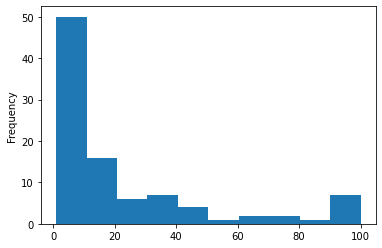

In [431]:
trt_venues.groupby('neighborhood').count()['venue'].plot(kind='hist')

The number of venues in a lot of neighborhoods are less than twenty. We'll analyze only the neighborhoods that have at least 20 venues.

In [432]:
# Generate a neighborhood list that only includes neighborhoods wiht more than ten venues.
temp = trt_venues.groupby('neighborhood').count()['venue']
venue_20 = temp[temp>=20].index.tolist()
trt_venues20 = trt_venues[trt_venues['neighborhood'].isin(venue_20)]

In [433]:
# Check the size of new dataframe.
trt_venues20.shape

(1677, 7)

We will transform the dataframe to meet conditions for applying K-means cluster.

In [434]:
# One hot coding
trt_onehot = pd.get_dummies(trt_venues20[['category']], prefix='', prefix_sep='')
# Add neighborhood column back to dataframe
trt_onehot['neighborhood'] = trt_venues20['neighborhood']
# Move neighborhood column to the first column
fixed_columns = [trt_onehot.columns[-1]] + list(trt_onehot.columns[:-1])
trt_onehot[fixed_columns].head()

,neighborhood,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Women's Store,Yoga Studio
7,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [435]:
# Check size of dataframe
trt_onehot.shape

(1677, 228)

Let's group rows by neighborhood and calculate the mean of the each category.

In [436]:
trt_mean = trt_onehot.groupby('neighborhood').mean().reset_index()
trt_mean.head()

,neighborhood,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Women's Store,Yoga Studio
0,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
1,"Bedford Park, Lawrence Manor East",0.0,0.045455,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
2,Berczy Park,0.0,0.000000,0.0,0.0,0.018182,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.018182,0.0,0.0,0.0,0.000000,0.0,0.000000
3,"Brockton, Parkdale Village, Exhibition Place",0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
4,Central Bay Street,0.0,0.000000,0.0,0.0,0.000000,0.014706,0.0,0.0,0.0,...,0.0,0.0,0.0,0.014706,0.0,0.0,0.0,0.014706,0.0,0.014706


We will create a dataframe that can display neighborhoods with their top ten most common venues and cluster labels. First, let's define a function that can return the top ten most common venues.

In [437]:
# Function for returning most common venues.
def most_common_venues(nh_row, number_top_common):
    top_venues = nh_row[1:].sort_values(ascending=False)[0: number_top_common].index.values
    return top_venues

Create the new dataframe.

In [452]:
# Create dataframe displaying top ten most common venues.
top_common = 10
col_suffix = ['st', 'nd', 'rd']

column_names = ['neighborhood']

for i in range(top_common):
    try:
        column_names.append('{}{} most common venue'.format(i+1, col_suffix[i]))
    except:
        column_names.append('{}st most common venue'.format(i+1))
        
trt_venue_clusters = pd.DataFrame(columns=column_names)
# Fill in the neighborhood name and top venue category
trt_venue_clusters['neighborhood'] = trt_mean['neighborhood']

for i in range(trt_mean.shape[0]):
    trt_venue_clusters.iloc[i, 1:] = most_common_venues(trt_mean.iloc[i, 1:], top_common)

trt_venue_clusters.head()

,neighborhood,1st most common venue,2nd most common venue,3rd most common venue,4st most common venue,5st most common venue,6st most common venue,7st most common venue,8st most common venue,9st most common venue,10st most common venue
0,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Sushi Restaurant,Ice Cream Shop,Sandwich Place,Bridal Shop,Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Diner
1,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Coffee Shop,American Restaurant,Pharmacy,Café,Restaurant,Pub,Pizza Place,Grocery Store
2,Berczy Park,Coffee Shop,Beer Bar,Cheese Shop,Farmers Market,Restaurant,Bakery,Seafood Restaurant,Cocktail Bar,Fountain,Sandwich Place
3,"Brockton, Parkdale Village, Exhibition Place",Café,Nightclub,Coffee Shop,Breakfast Spot,Furniture / Home Store,Convenience Store,Performing Arts Venue,Pet Store,Climbing Gym,Restaurant
4,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Japanese Restaurant,Burger Joint,Salad Place,Department Store,Bubble Tea Shop,Thai Restaurant


Now we will run k-means to cluster the neighborhoods into 5 clusers.

In [453]:
# Set number of clusters.
k = 5
trt_cluster = trt_mean.drop('neighborhood', axis=1)

k_means = KMeans(n_clusters=k, random_state=0)
k_means.fit(trt_cluster)
k_means.labels_

array([3, 2, 0, 1, 0, 4, 0, 2, 4, 4, 0, 4, 0, 1, 1, 4, 1, 0, 0, 4, 2, 4,
       2, 0, 4, 0, 3, 0, 2, 4], dtype=int32)

In [454]:
# Add cluster label into dataframe
trt_venue_clusters.insert(1, 'cluster label', k_means.labels_)


In [460]:
# Add latitude and longitude into dataframe for plotting folium map.
for i in range(trt_venue_clusters.shape[0]):
    nh = trt_venue_clusters.loc[i, 'neighborhood']
    idx = trt_nh[trt_nh['Neighborhood'] == nh].index.values
    trt_venue_clusters.loc[i, 'latitude'] = trt_nh.loc[idx, 'Latitude'].values[0]
    trt_venue_clusters.loc[i, 'longitude'] = trt_nh.loc[idx, 'Longitude'].values[0]

trt_venue_clusters.head()

,neighborhood,cluster label,1st most common venue,2nd most common venue,3rd most common venue,4st most common venue,5st most common venue,6st most common venue,7st most common venue,8st most common venue,9st most common venue,10st most common venue,latitude,lagitude,longitude
0,"Bathurst Manor, Wilson Heights, Downsview North",3,Bank,Coffee Shop,Sushi Restaurant,Ice Cream Shop,Sandwich Place,Bridal Shop,Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Diner,43.754328,-79.442259,-79.442259
1,"Bedford Park, Lawrence Manor East",2,Italian Restaurant,Sandwich Place,Coffee Shop,American Restaurant,Pharmacy,Café,Restaurant,Pub,Pizza Place,Grocery Store,43.733283,-79.419750,-79.419750
2,Berczy Park,0,Coffee Shop,Beer Bar,Cheese Shop,Farmers Market,Restaurant,Bakery,Seafood Restaurant,Cocktail Bar,Fountain,Sandwich Place,43.644771,-79.373306,-79.373306
3,"Brockton, Parkdale Village, Exhibition Place",1,Café,Nightclub,Coffee Shop,Breakfast Spot,Furniture / Home Store,Convenience Store,Performing Arts Venue,Pet Store,Climbing Gym,Restaurant,43.636847,-79.428191,-79.428191
4,Central Bay Street,0,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Japanese Restaurant,Burger Joint,Salad Place,Department Store,Bubble Tea Shop,Thai Restaurant,43.657952,-79.387383,-79.387383


Finally, let's visualize the cluster result in a folium map. <a id='map_clusters'></a>

In [461]:
# Create folium map
map_clusters = folium.Map(location=[trt_latt, trt_logt], zoom_start=10)

# Set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [467]:
# Add markers to the map
markers_color = []
for lat, lon, poi, cluster in zip(trt_venue_clusters['latitude'], trt_venue_clusters['longitude'], trt_venue_clusters['neighborhood'], trt_venue_clusters['cluster label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=5,
    popup=label,
    color=rainbow[cluster-1],
    fill=True,
    fill_color=rainbow[cluster-1]).add_to(map_clusters)
    
map_clusters